In [59]:
import pandas as pd

In [9]:
class Bible():
    def __init__(self):
        self.df = pd.read_csv("bible_data_set.csv")
        self.verse_group = self.df.groupby(['book','chapter','verse'])
        self.chapter_group = self.df.groupby(['book','chapter'])
        self.df['to_reference'] = self.df.apply(lambda x: x.book + '.' + str(x.chapter) + '.' + str(x.verse), axis=1)
        
    def get_verse(self, book, chapter, verse):
        return self.verse_group.get_group((book, chapter, verse)).text.iloc[0].strip(' \n')
    
    def get_verse_num(self, book, chapter):
        return len(self.chapter_group.get_group((book, chapter)))

In [10]:
bible = Bible()

In [11]:
bible.df

,citation,book,chapter,verse,text,to_reference
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,Genesis.1.1
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",Genesis.1.2
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",Genesis.1.3
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",Genesis.1.4
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",Genesis.1.5
...,...,...,...,...,...,...
31097,Revelation 22:17,Revelation,22,17,"And the Spirit and the bride say, Come. And le...",Revelation.22.17
31098,Revelation 22:18,Revelation,22,18,For I testify unto every man that heareth the ...,Revelation.22.18
31099,Revelation 22:19,Revelation,22,19,And if any man shall take away from the words ...,Revelation.22.19
31100,Revelation 22:20,Revelation,22,20,"He which testifieth these things saith, Surely...",Revelation.22.20


In [12]:
class Cross_reference():
    def __init__(self):
        self.df = pd.read_csv("cross_reference.txt", delimiter="\t")
        self.bible = Bible()
        self.not_existing_verses = {'2 John.1.14', '2 John.1.15', '3 John.1.15'}
        # honorably genreated by ChatGPT
        # Create a dictionary of book abbreviations and their full names
        self.bible_abb_books = {
            "Gen": "Genesis",
            "Exod": "Exodus",
            "Lev": "Leviticus",
            "Num": "Numbers",
            "Deut": "Deuteronomy",
            "Josh": "Joshua",
            "Judg": "Judges",
            "Ruth": "Ruth",
            "1Sam": "1 Samuel",
            "2Sam": "2 Samuel",
            "1Kgs": "1 Kings",
            "2Kgs": "2 Kings",
            "1Chr": "1 Chronicles",
            "2Chr": "2 Chronicles",
            "Ezra": "Ezra",
            "Neh": "Nehemiah",
            "Esth": "Esther",
            "Job": "Job",
            "Ps": "Psalms",
            "Prov": "Proverbs",
            "Eccl": "Ecclesiastes",
            "Song": "Song of Solomon",
            "Isa": "Isaiah",
            "Jer": "Jeremiah",
            "Lam": "Lamentations",
            "Ezek": "Ezekiel",
            "Dan": "Daniel",
            "Hos": "Hosea",
            "Joel": "Joel",
            "Amos": "Amos",
            "Obad": "Obadiah",
            "Jonah": "Jonah",
            "Mic": "Micah",
            "Nah": "Nahum",
            "Hab": "Habakkuk",
            "Zeph": "Zephaniah",
            "Hag": "Haggai",
            "Zech": "Zechariah",
            "Mal": "Malachi",
            "Matt": "Matthew",
            "Mark": "Mark",
            "Luke": "Luke",
            "John": "John",
            "Acts": "Acts",
            "Rom": "Romans",
            "1Cor": "1 Corinthians",
            "2Cor": "2 Corinthians",
            "Gal": "Galatians",
            "Eph": "Ephesians",
            "Phil": "Philippians",
            "Col": "Colossians",
            "1Thess": "1 Thessalonians",
            "2Thess": "2 Thessalonians",
            "1Tim": "1 Timothy",
            "2Tim": "2 Timothy",
            "Titus": "Titus",
            "Phlm": "Philemon",
            "Heb": "Hebrews",
            "Jas": "James",
            "1Pet": "1 Peter",
            "2Pet": "2 Peter",
            "1John": "1 John",
            "2John": "2 John",
            "3John": "3 John",
            "Jude": "Jude",
            "Rev": "Revelation"
        }
    
    
    def print_unique_verses_num(self):
        print(len(self.df['From Verse'].unique()))
        print(len(self.df['To Verse'].unique()))
        
    
    def preprocess_to_verse(self):
        # deal with multiple verses case
        self.df['To Verse'] = self.df['To Verse'].apply(lambda x:x.split('-')).apply(self.fill_list)
        # Just ignore all the to verses that cross books because they are not that important in our analysis
        self.df = self.df[self.df['To Verse'].map(lambda d: len(d)) > 0]
        self.df['Indicator'] = self.df['To Verse'].apply(lambda x: any(a in self.not_existing_verses for a in x))
        self.df = self.df[self.df['Indicator'] == False]
        self.df = self.df.dropna()
        # self.df = self.df[~self.df['To Verse'].isin(self.not_existing_verses)]
        self.df['tt'] = self.df['To Verse'].apply(self.generate_text)
        self.df['tb'] = self.df['To Verse'].apply(lambda x: x[0].split('.')[0])
        
    def preprocess_from_verse(self):
        self.df['From Verse'] = self.df['From Verse'].apply(lambda x:[self.get_whole_book_name(x.split(".")[0]) + '.' + x.split(".")[1] + '.' + x.split(".")[2]])
        self.df['Indicator'] = self.df['From Verse'].apply(lambda x: any(a in self.not_existing_verses for a in x))
        self.df = self.df[self.df['Indicator'] == False]
        self.df['fb'] = self.df['From Verse'].apply(lambda x: x[0].split('.')[0])
        self.df['ft'] = self.df['From Verse'].apply(self.generate_text)
    
    def generate_text(self, l):
        text = ""
        for v in l:
            x = v.split('.')
            t = self.bible.get_verse(x[0], int(x[1]), int(x[2]))
            text += t
        return text
    
    def check_no_existing_verses(self, column):
        self.not_existing_verses = self.not_existing_verses | (set(self.df[column]) - set(self.bible.df.to_reference.unique()))
    
    '''
    Given a list, return a filled list with all the verses in the list range
    '''
    def fill_list(self, l):
        # one verse
        if len(l) == 1:
            b,c,v = l[0].split('.')
            book = self.get_whole_book_name(b)
            return [book + '.' + c + '.' + v]
        book = self.get_whole_book_name(l[0].split('.')[0])
        start_c = int(l[0].split('.')[1])
        end_c = int(l[1].split('.')[1])
        start_v = int(l[0].split('.')[2])
        end_v = int(l[1].split('.')[2])
        # print(book, ':', start_c, end_c, start_v, end_v)

        # multiple verses but in the same chapter
        if (start_c == end_c):
            new_l = []
            for i in range(start_v, end_v + 1):
                new_l.append(book + '.' + str(end_c) + '.' + str(i))
            return new_l
        # cross chapter case
        else:
            new_l = []
            # print(start_c, end_c + 1)
            for c in range(start_c, end_c + 1):
                # print(c)
                if c == start_c:
                    sv = start_v
                    ev = bible.get_verse_num(book, c)
                elif (c != start_c and c != end_c):
                    sv = 1
                    ev = bible.get_verse_num(book, c)
                else:
                    sv = 1
                    ev = end_v
                # print("sv: ", sv, "ev: ", ev)
                for v in range(sv, ev + 1):
                    new_l.append(book + '.' + str(c) + '.' + str(v))
            return new_l
        
    
    def get_whole_book_name(self, abb):
        return self.bible_abb_books.get(abb, "")

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


def get_embedding_similarity(sentences, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    # print(sentence_embeddings)
    # print(type(sentence_embeddings))
    # print(type(sentence_embeddings[0]))
    # compute the cosine similarity
    cos = torch.nn.CosineSimilarity(dim=0)
    similarity = cos(sentence_embeddings[0], sentence_embeddings[1])

    return similarity

In [14]:
cr = Cross_reference()
cr.df

,From Verse,To Verse,Votes
0,Gen.1.1,John.1.1-John.1.3,217
1,Gen.1.1,Ps.104.30,33
2,Gen.1.1,Rev.10.6,37
3,Gen.1.1,Ps.121.2,36
4,Gen.1.1,1Cor.8.6,40
...,...,...,...
344784,Rev.22.21,2Cor.13.14,5
344785,Rev.22.21,2Thess.3.18,7
344786,Rev.22.21,Rom.16.20,5
344787,Rev.22.21,Rev.1.4,-1


In [15]:
cr.df.iloc[30642]

From Verse              Num.3.1
To Verse      Lev.27.34-Num.1.1
Votes                         2
Name: 30642, dtype: object

In [99]:
cr.not_existing_verses
cr.df[~cr.df['To Verse'].isin(cr.not_existing_verses)]

,From Verse,To Verse,Votes
0,Gen.1.1,John.1.1-John.1.3,217
1,Gen.1.1,Ps.104.30,33
2,Gen.1.1,Rev.10.6,37
3,Gen.1.1,Ps.121.2,36
4,Gen.1.1,1Cor.8.6,40
...,...,...,...
344784,Rev.22.21,2Cor.13.14,5
344785,Rev.22.21,2Thess.3.18,7
344786,Rev.22.21,Rom.16.20,5
344787,Rev.22.21,Rev.1.4,-1


In [166]:
cr.preprocess_to_verse()
cr.preprocess_from_verse()

C:\Users\fangz\AppData\Local\Temp\ipykernel_14808\1636441183.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Indicator'] = self.df['To Verse'].apply(lambda x: any(a in self.not_existing_verses for a in x))


In [ ]:
cr.df[cr.df.isna().any(axis=1)]

In [146]:
cr.df['check'] = cr.df['To Verse'].apply(len)

In [148]:
cr.df[cr.df['check'] < 1]

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,check
30642,Numbers.3.1,[],2,False,,[],N,0
93620,Ezra.4.3,[],2,False,,[],E,0
93913,Ezra.6.3,[],4,False,,[],E,0
167485,Isaiah.44.28,[],7,False,,[],I,0
183891,Jeremiah.27.22,[],2,False,,[],J,0
184154,Jeremiah.29.10,[],5,False,,[],J,0
205286,Ezekiel.36.3,[],2,False,,[],E,0
210663,Daniel.6.28,[],1,False,,[],D,0
211985,Daniel.10.1,[],3,False,,[],D,0
224757,Haggai.1.1,[],2,False,,[],H,0


In [115]:
cr.df[cr.df.Indicator == True]

,From Verse,To Verse,Votes,Indicator
274912,Acts.1.13,"[2 John.1.1, 2 John.1.2, 2 John.1.3, 2 John.1....",1,True
280664,Acts.11.30,"[2 John.1.1, 2 John.1.2, 2 John.1.3, 2 John.1....",2,True
334021,1Pet.5.1,"[2 John.1.1, 2 John.1.2, 2 John.1.3, 2 John.1....",5,True
336651,1John.3.18,"[2 John.1.1, 2 John.1.2, 2 John.1.3, 2 John.1....",7,True
337521,2John.1.1,"[2 John.1.13, 2 John.1.14, 2 John.1.15]",4,True


In [10]:
cr.not_existing_verses

{'2 John.1.14', '2 John.1.15', '3 John.1.15'}

In [167]:
cr.df.sort_values(['Votes'])

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft
50,[Genesis.1.1],[Exodus.31.18],-32,False,"And he gave unto Moses, when he had made an en...",Exodus,Genesis,In the beginning God created the heaven and th...
132782,[Psalms.110.1],[Luke.22.41],-21,False,And he was withdrawn from them about a stone's...,Luke,Psalms,"The LORD said unto my Lord, Sit thou at my rig..."
65,[Genesis.1.2],[Nahum.2.10],-15,False,"She is empty, and void, and waste: and the hea...",Nahum,Genesis,"And the earth was without form, and void; and ..."
258439,[Luke.15.11],"[Matthew.21.23, Matthew.21.24, Matthew.21.25, ...",-14,False,"And when he was come into the temple, the chie...",Matthew,Luke,"And he said, A certain man had two sons:"
332354,[1 Peter.1.16],[Amos.3.3],-14,False,"Can two walk together, except they be agreed?",Amos,1 Peter,"Because it is written, Be ye holy; for I am holy."
...,...,...,...,...,...,...,...,...
167013,[Isaiah.44.3],[Acts.2.17],863,False,"And it shall come to pass in the last days, sa...",Acts,Isaiah,For I will pour water upon him that is thirsty...
184186,[Jeremiah.29.11],"[Isaiah.55.8, Isaiah.55.9, Isaiah.55.10, Isaia...",906,False,"For my thoughts are not your thoughts, neither...",Isaiah,Jeremiah,For I know the thoughts that I think toward yo...
167030,[Isaiah.44.3],[Joel.2.28],966,False,"And it shall come to pass afterward, that I wi...",Joel,Isaiah,For I will pour water upon him that is thirsty...
292114,[Romans.8.29],[Jeremiah.1.5],1095,False,Before I formed thee in the belly I knew thee;...,Jeremiah,Romans,"For whom he did foreknow, he also did predesti..."


In [11]:
get_embedding_similarity(sentences, tokenizer, model)

tensor(0.4046)

In [174]:
def get_similarity_wrapper(sentence1, sentence2, tokenizer, model, bible):
    return get_embedding_similarity([sentence1, sentence2], tokenizer, model)

In [175]:
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

In [177]:
similarity = cr.df.progress_apply(lambda df:get_similarity_wrapper(df['ft'], df['tt'], tokenizer, model, cr.bible), axis=1)

  0%|          | 0/344770 [00:00<?, ?it/s]

In [178]:
a = similarity.apply(lambda x: x.numpy())

In [179]:
cr.df['similarity'] = a

In [180]:
cr.df

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity
0,[Genesis.1.1],"[John.1.1, John.1.2, John.1.3]",217,False,"In the beginning was the Word, and the Word wa...",John,Genesis,In the beginning God created the heaven and th...,0.517112
1,[Genesis.1.1],[Psalms.104.30],33,False,"Thou sendest forth thy spirit, they are create...",Psalms,Genesis,In the beginning God created the heaven and th...,0.490014
2,[Genesis.1.1],[Revelation.10.6],37,False,And sware by him that liveth for ever and ever...,Revelation,Genesis,In the beginning God created the heaven and th...,0.576545
3,[Genesis.1.1],[Psalms.121.2],36,False,"My help cometh from the LORD, which made heave...",Psalms,Genesis,In the beginning God created the heaven and th...,0.719329
4,[Genesis.1.1],[1 Corinthians.8.6],40,False,"But to us there is but one God, the Father, of...",1 Corinthians,Genesis,In the beginning God created the heaven and th...,0.356431
...,...,...,...,...,...,...,...,...,...
344784,[Revelation.22.21],[2 Corinthians.13.14],5,False,"The grace of the Lord Jesus Christ, and the lo...",2 Corinthians,Revelation,The grace of our Lord Jesus Christ be with you...,0.818452
344785,[Revelation.22.21],[2 Thessalonians.3.18],7,False,The grace of our Lord Jesus Christ be with you...,2 Thessalonians,Revelation,The grace of our Lord Jesus Christ be with you...,1.000000
344786,[Revelation.22.21],[Romans.16.20],5,False,And the God of peace shall bruise Satan under ...,Romans,Revelation,The grace of our Lord Jesus Christ be with you...,0.536710
344787,[Revelation.22.21],[Revelation.1.4],-1,False,John to the seven churches which are in Asia: ...,Revelation,Revelation,The grace of our Lord Jesus Christ be with you...,0.398616


In [181]:
cr.df.to_csv('cross_reference_with_similarity_1.csv', index=False)

In [16]:
import pandas as pd

In [17]:
crs = pd.read_csv('cross_reference_with_similarity_1.csv')

In [18]:
crs

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity
0,['Genesis.1.1'],"['John.1.1', 'John.1.2', 'John.1.3']",217,False,"In the beginning was the Word, and the Word wa...",John,Genesis,In the beginning God created the heaven and th...,0.517112
1,['Genesis.1.1'],['Psalms.104.30'],33,False,"Thou sendest forth thy spirit, they are create...",Psalms,Genesis,In the beginning God created the heaven and th...,0.490014
2,['Genesis.1.1'],['Revelation.10.6'],37,False,And sware by him that liveth for ever and ever...,Revelation,Genesis,In the beginning God created the heaven and th...,0.576545
3,['Genesis.1.1'],['Psalms.121.2'],36,False,"My help cometh from the LORD, which made heave...",Psalms,Genesis,In the beginning God created the heaven and th...,0.719329
4,['Genesis.1.1'],['1 Corinthians.8.6'],40,False,"But to us there is but one God, the Father, of...",1 Corinthians,Genesis,In the beginning God created the heaven and th...,0.356431
...,...,...,...,...,...,...,...,...,...
344765,['Revelation.22.21'],['2 Corinthians.13.14'],5,False,"The grace of the Lord Jesus Christ, and the lo...",2 Corinthians,Revelation,The grace of our Lord Jesus Christ be with you...,0.818452
344766,['Revelation.22.21'],['2 Thessalonians.3.18'],7,False,The grace of our Lord Jesus Christ be with you...,2 Thessalonians,Revelation,The grace of our Lord Jesus Christ be with you...,1.000000
344767,['Revelation.22.21'],['Romans.16.20'],5,False,And the God of peace shall bruise Satan under ...,Romans,Revelation,The grace of our Lord Jesus Christ be with you...,0.536710
344768,['Revelation.22.21'],['Revelation.1.4'],-1,False,John to the seven churches which are in Asia: ...,Revelation,Revelation,The grace of our Lord Jesus Christ be with you...,0.398616


In [19]:
crs.describe()

,Votes,similarity
count,344770.000000,344770.000000
mean,4.759147,0.437165
std,11.897619,0.137123
min,-32.000000,-0.094726
25%,2.000000,0.346397
50%,3.000000,0.432726
75%,4.000000,0.522045
max,1221.000000,1.000000


<AxesSubplot:xlabel='Votes', ylabel='similarity'>

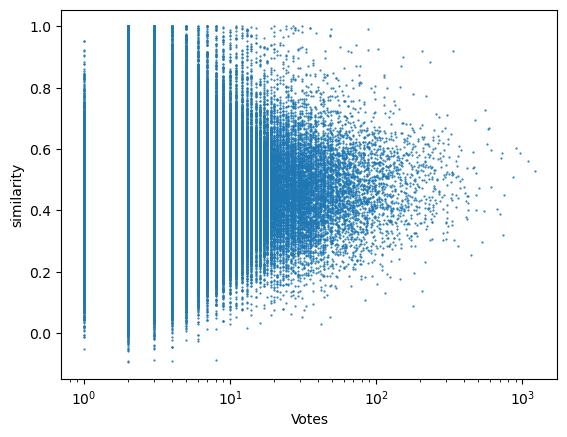

In [20]:
crs.plot.scatter(x='Votes', y="similarity", logx=True, s= 0.3)

In [21]:
import matplotlib.pyplot as plt

(array([3.43978e+05, 6.25000e+02, 1.15000e+02, 2.80000e+01, 1.10000e+01,
        4.00000e+00, 4.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([ -32. ,   93.3,  218.6,  343.9,  469.2,  594.5,  719.8,  845.1,
         970.4, 1095.7, 1221. ]),
 <BarContainer object of 10 artists>)

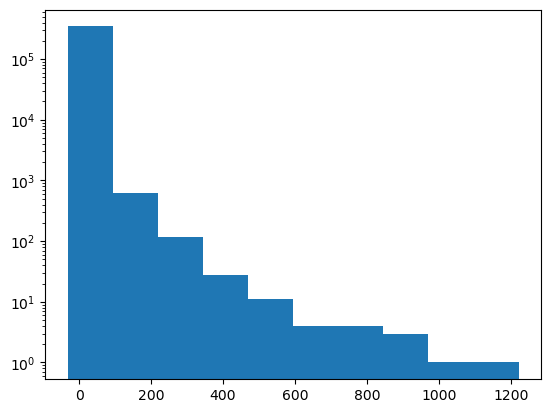

In [22]:
plt.hist(crs.Votes, log=True)

In [23]:
crs[(crs['Votes'] > 4) & (crs['similarity'] > 0.8)].sort_values(['Votes'])

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity
176233,['Jeremiah.5.9'],['Jeremiah.9.9'],5,False,Shall I not visit them for these things? saith...,Jeremiah,Jeremiah,Shall I not visit for these things? saith the ...,0.965412
83040,['1 Chronicles.15.3'],['1 Chronicles.13.5'],5,False,"So David gathered all Israel together, from Sh...",1 Chronicles,1 Chronicles,And David gathered all Israel together to Jeru...,0.841083
81666,['1 Chronicles.6.19'],['1 Chronicles.23.21'],5,False,"The sons of Merari; Mahli, and Mushi. The sons...",1 Chronicles,1 Chronicles,"The sons of Merari; Mahli, and Mushi. And thes...",0.828932
81573,['1 Chronicles.6.1'],['Genesis.46.11'],5,False,"And the sons of Levi; Gershon, Kohath, and Mer...",Genesis,1 Chronicles,"The sons of Levi; Gershon, Kohath, and Merari.",0.955281
81474,['1 Chronicles.5.3'],['Exodus.6.14'],5,False,These be the heads of their fathers' houses: T...,Exodus,1 Chronicles,"The sons, I say, of Reuben the firstborn of Is...",0.845417
...,...,...,...,...,...,...,...,...,...
326609,['Hebrews.8.10'],"['Hebrews.10.16', 'Hebrews.10.17']",148,False,This is the covenant that I will make with the...,Hebrews,Hebrews,For this is the covenant that I will make with...,0.870722
252511,['Luke.4.18'],['Isaiah.61.1'],153,False,The Spirit of the Lord GOD is upon me; because...,Isaiah,Luke,"The Spirit of the Lord is upon me, because he ...",0.900236
326641,['Hebrews.8.10'],['Jeremiah.31.33'],207,False,But this shall be the covenant that I will mak...,Jeremiah,Hebrews,For this is the covenant that I will make with...,0.921058
172625,['Isaiah.61.1'],"['Luke.4.18', 'Luke.4.19']",235,False,"The Spirit of the Lord is upon me, because he ...",Luke,Isaiah,The Spirit of the Lord GOD is upon me; because...,0.884894


In [24]:
crs[(crs['Votes'] > 4) & (crs['similarity'] < 0.3)].sort_values(['Votes'])

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity
128828,['Psalms.94.18'],['1 Peter.1.5'],5,False,Who are kept by the power of God through faith...,1 Peter,Psalms,"When I said, My foot slippeth; thy mercy, O LO...",0.230271
141529,['Proverbs.6.23'],['Proverbs.29.15'],5,False,The rod and reproof give wisdom: but a child l...,Proverbs,Proverbs,For the commandment is a lamp; and the law is ...,0.242076
141531,['Proverbs.6.23'],['Leviticus.19.17'],5,False,Thou shalt not hate thy brother in thine heart...,Leviticus,Proverbs,For the commandment is a lamp; and the law is ...,0.251381
277070,['Acts.5.13'],['Acts.2.47'],5,False,"Praising God, and having favour with all the p...",Acts,Acts,And of the rest durst no man join himself to t...,0.166283
141541,['Proverbs.6.24'],['Proverbs.5.3'],5,False,For the lips of a strange woman drop as an hon...,Proverbs,Proverbs,"To keep thee from the evil woman, from the fla...",0.260584
...,...,...,...,...,...,...,...,...,...
179975,['Jeremiah.15.16'],['Psalms.19.10'],205,False,"More to be desired are they than gold, yea, th...",Psalms,Jeremiah,"Thy words were found, and I did eat them; and ...",0.136773
141074,['Proverbs.4.23'],"['James.1.14', 'James.1.15']",216,False,"But every man is tempted, when he is drawn awa...",James,Proverbs,Keep thy heart with all diligence; for out of ...,0.233430
293827,['Romans.12.2'],['1 Peter.1.14'],361,False,"As obedient children, not fashioning yourselve...",1 Peter,Romans,And be not conformed to this world: but be ye ...,0.283118
141078,['Proverbs.4.23'],"['Mark.7.21', 'Mark.7.22', 'Mark.7.23']",444,False,"For from within, out of the heart of men, proc...",Mark,Proverbs,Keep thy heart with all diligence; for out of ...,0.254493


In [25]:
crs[(crs['Votes'] < 0) & (crs['similarity'] >0.52)].sort_values(['similarity'])

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity
244690,['Mark.3.1'],['1 Kings.13.4'],-2,False,"And it came to pass, when king Jeroboam heard ...",1 Kings,Mark,And he entered again into the synagogue; and t...,0.520243
269055,['John.10.34'],['John.8.17'],-5,False,"It is also written in your law, that the testi...",John,John,"Jesus answered them, Is it not written in your...",0.520700
269061,['John.10.34'],['1 Corinthians.14.21'],-11,False,"In the law it is written, With men of other to...",1 Corinthians,John,"Jesus answered them, Is it not written in your...",0.520810
165168,['Isaiah.40.4'],['Proverbs.2.15'],-1,False,"Whose ways are crooked, and they froward in th...",Proverbs,Isaiah,"Every valley shall be exalted, and every mount...",0.521997
264272,['John.3.17'],['Luke.9.56'],-2,False,For the Son of man is not come to destroy men'...,Luke,John,For God sent not his Son into the world to con...,0.522026
...,...,...,...,...,...,...,...,...,...
145,['Genesis.1.8'],['Genesis.1.19'],-1,False,And the evening and the morning were the fourt...,Genesis,Genesis,And God called the firmament Heaven. And the e...,0.724262
170506,['Isaiah.54.5'],['Isaiah.48.2'],-1,False,"For they call themselves of the holy city, and...",Isaiah,Isaiah,For thy Maker is thine husband; the LORD of ho...,0.724979
147,['Genesis.1.8'],['Genesis.1.13'],-2,False,And the evening and the morning were the third...,Genesis,Genesis,And God called the firmament Heaven. And the e...,0.750118
16354,['Exodus.14.1'],['Exodus.12.1'],-1,False,And the LORD spake unto Moses and Aaron in the...,Exodus,Exodus,"And the LORD spake unto Moses, saying,",0.874669


Even though in some cases, the bible used the same word, they are not really cross references to each other like mentioned here "And the LORD spake unto Moses, saying" 

In [26]:
crs.corr()

,Votes,Indicator,similarity
Votes,1.000000,NaN,0.057466
Indicator,NaN,NaN,NaN
similarity,0.057466,NaN,1.000000


In [27]:
crs[(crs['Votes'] > 0)].sort_values(['Votes'])

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity
330384,['James.2.5'],['Zephaniah.3.12'],1,False,I will also leave in the midst of thee an affl...,Zephaniah,James,"Hearken, my beloved brethren, Hath not God cho...",0.527759
339368,['Revelation.3.10'],['Luke.2.1'],1,False,"And it came to pass in those days, that there ...",Luke,Revelation,Because thou hast kept the word of my patience...,0.169596
199600,['Ezekiel.18.17'],['Luke.19.8'],1,False,"And Zacchaeus stood, and said unto the Lord: B...",Luke,Ezekiel,"That hath taken off his hand from the poor, th...",0.474164
117168,['Psalms.38.11'],['Isaiah.53.8'],1,False,He was taken from prison and from judgment: an...,Isaiah,Psalms,My lovers and my friends stand aloof from my s...,0.060399
168590,['Isaiah.48.8'],['Jeremiah.5.21'],1,False,"Hear now this, O foolish people, and without u...",Jeremiah,Isaiah,"Yea, thou heardest not; yea, thou knewest not;...",0.551878
...,...,...,...,...,...,...,...,...,...
167010,['Isaiah.44.3'],['Acts.2.17'],863,False,"And it shall come to pass in the last days, sa...",Acts,Isaiah,For I will pour water upon him that is thirsty...,0.509553
184180,['Jeremiah.29.11'],"['Isaiah.55.8', 'Isaiah.55.9', 'Isaiah.55.10',...",906,False,"For my thoughts are not your thoughts, neither...",Isaiah,Jeremiah,For I know the thoughts that I think toward yo...,0.602763
167027,['Isaiah.44.3'],['Joel.2.28'],966,False,"And it shall come to pass afterward, that I wi...",Joel,Isaiah,For I will pour water upon him that is thirsty...,0.586937
292099,['Romans.8.29'],['Jeremiah.1.5'],1095,False,Before I formed thee in the belly I knew thee;...,Jeremiah,Romans,"For whom he did foreknow, he also did predesti...",0.560714


In [28]:
crs[(crs['Votes'] <= 0)].sort_values(['Votes'])

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity
50,['Genesis.1.1'],['Exodus.31.18'],-32,False,"And he gave unto Moses, when he had made an en...",Exodus,Genesis,In the beginning God created the heaven and th...,0.377933
132779,['Psalms.110.1'],['Luke.22.41'],-21,False,And he was withdrawn from them about a stone's...,Luke,Psalms,"The LORD said unto my Lord, Sit thou at my rig...",0.277634
65,['Genesis.1.2'],['Nahum.2.10'],-15,False,"She is empty, and void, and waste: and the hea...",Nahum,Genesis,"And the earth was without form, and void; and ...",0.487141
258429,['Luke.15.11'],"['Matthew.21.23', 'Matthew.21.24', 'Matthew.21...",-14,False,"And when he was come into the temple, the chie...",Matthew,Luke,"And he said, A certain man had two sons:",0.392056
332339,['1 Peter.1.16'],['Amos.3.3'],-14,False,"Can two walk together, except they be agreed?",Amos,1 Peter,"Because it is written, Be ye holy; for I am holy.",0.020069
...,...,...,...,...,...,...,...,...,...
256962,['Luke.12.7'],['Matthew.12.12'],0,False,How much then is a man better than a sheep? Wh...,Matthew,Luke,But even the very hairs of your head are all n...,0.287078
256964,['Luke.12.7'],['Job.35.11'],0,False,Who teacheth us more than the beasts of the ea...,Job,Luke,But even the very hairs of your head are all n...,0.386754
257148,['Luke.12.20'],"['Exodus.16.9', 'Exodus.16.10']",0,False,"And Moses spake unto Aaron, Say unto all the c...",Exodus,Luke,"But God said unto him, Thou fool, this night t...",0.381067
256644,['Luke.11.34'],['Ephesians.6.5'],0,False,"Servants, be obedient to them that are your ma...",Ephesians,Luke,The light of the body is the eye: therefore wh...,0.285194


In [29]:
fcrs = crs[(crs['Votes'] >= 4)].sort_values(['Votes'])

In [30]:
# normalize the votes
fcrs['NVotes'] = fcrs['Votes'].div(fcrs.groupby('From Verse')['Votes'].transform('sum'))

In [31]:
fcrs.corr()

,Votes,Indicator,similarity,NVotes
Votes,1.000000,NaN,0.027942,-0.101705
Indicator,NaN,NaN,NaN,NaN
similarity,0.027942,NaN,1.000000,0.196087
NVotes,-0.101705,NaN,0.196087,1.000000


<AxesSubplot:xlabel='NVotes', ylabel='similarity'>

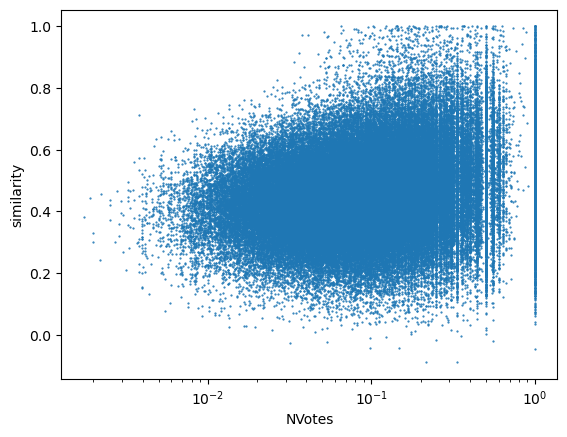

In [32]:
fcrs.plot.scatter(x='NVotes', y="similarity", logx=True, s= 0.3)

(array([5.7623e+04, 2.6735e+04, 1.1652e+04, 7.0870e+03, 5.7310e+03,
        2.0680e+03, 3.2200e+02, 4.6000e+01, 1.6000e+01, 5.5630e+03]),
 array([0.00174902, 0.10157411, 0.20139921, 0.30122431, 0.40104941,
        0.50087451, 0.60069961, 0.7005247 , 0.8003498 , 0.9001749 ,
        1.        ]),
 <BarContainer object of 10 artists>)

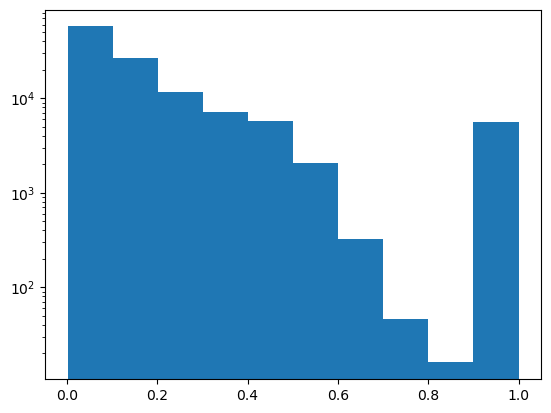

In [33]:
plt.hist(fcrs.NVotes, log=True)

In [34]:
fcrs['From Verse'] = fcrs['From Verse'].apply(lambda x:x[2:-2])

In [35]:
fcrs.similarity.mean()

0.4617349955399713

In [36]:
fcrs

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity,NVotes
332689,1 Peter.2.5,['Philippians.1.11'],4,False,"Being filled with the fruits of righteousness,...",Philippians,1 Peter,"Ye also, as lively stones, are built up a spir...",0.376150,0.013115
231177,Matthew.3.16,['Isaiah.59.21'],4,False,"As for me, this is my covenant with them, sait...",Isaiah,Matthew,"And Jesus, when he was baptized, went up strai...",0.410811,0.041667
117911,Psalms.42.11,['Matthew.9.12'],4,False,"But when Jesus heard that, he said unto them, ...",Matthew,Psalms,"Why art thou cast down, O my soul? and why art...",0.221183,0.080000
117913,Psalms.43.1,['Psalms.5.6'],4,False,Thou shalt destroy them that speak leasing: th...,Psalms,Psalms,"Judge me, O God, and plead my cause against an...",0.400111,0.125000
231164,Matthew.3.15,['Luke.1.6'],4,False,"And they were both righteous before God, walki...",Luke,Matthew,"And Jesus answering said unto him, Suffer it t...",0.373658,0.065574
...,...,...,...,...,...,...,...,...,...,...
167010,Isaiah.44.3,['Acts.2.17'],863,False,"And it shall come to pass in the last days, sa...",Acts,Isaiah,For I will pour water upon him that is thirsty...,0.509553,0.108376
184180,Jeremiah.29.11,"['Isaiah.55.8', 'Isaiah.55.9', 'Isaiah.55.10',...",906,False,"For my thoughts are not your thoughts, neither...",Isaiah,Jeremiah,For I know the thoughts that I think toward yo...,0.602763,0.177612
167027,Isaiah.44.3,['Joel.2.28'],966,False,"And it shall come to pass afterward, that I wi...",Joel,Isaiah,For I will pour water upon him that is thirsty...,0.586937,0.121311
292099,Romans.8.29,['Jeremiah.1.5'],1095,False,Before I formed thee in the belly I knew thee;...,Jeremiah,Romans,"For whom he did foreknow, he also did predesti...",0.560714,0.113577


In [37]:
fcrs[fcrs.tb != fcrs.fb].sort_values('similarity').tail(20)

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity,NVotes
18223,Exodus.20.7,['Deuteronomy.5.11'],26,False,Thou shalt not take the name of the LORD thy G...,Deuteronomy,Exodus,Thou shalt not take the name of the LORD thy G...,0.995554,0.209677
39366,Deuteronomy.5.11,['Exodus.20.7'],28,False,Thou shalt not take the name of the LORD thy G...,Exodus,Deuteronomy,Thou shalt not take the name of the LORD thy G...,0.995554,0.736842
231071,Matthew.3.10,['Luke.3.9'],14,False,And now also the axe is laid unto the root of ...,Luke,Matthew,And now also the axe is laid unto the root of ...,0.996810,0.104478
252116,Luke.3.9,['Matthew.3.10'],5,False,And now also the axe is laid unto the root of ...,Matthew,Luke,And now also the axe is laid unto the root of ...,0.996810,0.151515
192403,Jeremiah.52.1,['2 Kings.24.18'],4,False,Zedekiah was twenty and one years old when he ...,2 Kings,Jeremiah,Zedekiah was one and twenty years old when he ...,0.997585,0.500000
244245,Mark.1.24,['Luke.4.34'],5,False,"Saying, Let us alone; what have we to do with ...",Luke,Mark,"Saying, Let us alone; what have we to do with ...",0.998869,0.185185
252702,Luke.4.34,['Mark.1.24'],7,False,"Saying, Let us alone; what have we to do with ...",Mark,Luke,"Saying, Let us alone; what have we to do with ...",0.998869,0.259259
96401,Nehemiah.7.65,['Ezra.2.63'],4,False,"And the Tirshatha said unto them, that they sh...",Ezra,Nehemiah,"And the Tirshatha said unto them, that they sh...",0.998995,0.181818
241604,Matthew.24.46,['Luke.12.43'],4,False,"Blessed is that servant, whom his lord when he...",Luke,Matthew,"Blessed is that servant, whom his lord when he...",1.000000,0.266667
261204,Luke.21.33,['Mark.13.31'],24,False,Heaven and earth shall pass away: but my words...,Mark,Luke,Heaven and earth shall pass away: but my words...,1.000000,0.169014


In [38]:
tfcrs = fcrs[fcrs.tb != fcrs.fb]

In [39]:
tfcrs

,From Verse,To Verse,Votes,Indicator,tt,tb,fb,ft,similarity,NVotes
332689,1 Peter.2.5,['Philippians.1.11'],4,False,"Being filled with the fruits of righteousness,...",Philippians,1 Peter,"Ye also, as lively stones, are built up a spir...",0.376150,0.013115
231177,Matthew.3.16,['Isaiah.59.21'],4,False,"As for me, this is my covenant with them, sait...",Isaiah,Matthew,"And Jesus, when he was baptized, went up strai...",0.410811,0.041667
117911,Psalms.42.11,['Matthew.9.12'],4,False,"But when Jesus heard that, he said unto them, ...",Matthew,Psalms,"Why art thou cast down, O my soul? and why art...",0.221183,0.080000
231164,Matthew.3.15,['Luke.1.6'],4,False,"And they were both righteous before God, walki...",Luke,Matthew,"And Jesus answering said unto him, Suffer it t...",0.373658,0.065574
117932,Psalms.43.2,['Ephesians.6.10'],4,False,"Finally, my brethren, be strong in the Lord, a...",Ephesians,Psalms,For thou art the God of my strength: why dost ...,0.401696,0.266667
...,...,...,...,...,...,...,...,...,...,...
167010,Isaiah.44.3,['Acts.2.17'],863,False,"And it shall come to pass in the last days, sa...",Acts,Isaiah,For I will pour water upon him that is thirsty...,0.509553,0.108376
184180,Jeremiah.29.11,"['Isaiah.55.8', 'Isaiah.55.9', 'Isaiah.55.10',...",906,False,"For my thoughts are not your thoughts, neither...",Isaiah,Jeremiah,For I know the thoughts that I think toward yo...,0.602763,0.177612
167027,Isaiah.44.3,['Joel.2.28'],966,False,"And it shall come to pass afterward, that I wi...",Joel,Isaiah,For I will pour water upon him that is thirsty...,0.586937,0.121311
292099,Romans.8.29,['Jeremiah.1.5'],1095,False,Before I formed thee in the belly I knew thee;...,Jeremiah,Romans,"For whom he did foreknow, he also did predesti...",0.560714,0.113577


In [40]:
tfcrs.similarity.mean()

0.4439063557379043

In [70]:
def get_recommendation(df, book, chapter, verse, query_num, by):
    bible = Bible()
    try:
        bible.get_verse(book, chapter, verse)
        verse_name = book + '.' + str(chapter) + '.' + str(verse)
    except:
        return {'result_codes': [], 'result_texts': [], 'error': "This verse doesn't exist."}
    temp = df[df['From Verse'] == verse_name].sort_values([by], ascending=False).head(query_num)
    print(temp[['To Verse', 'tt']])
    if (len(temp) == 0):
        return {'result_codes': list(temp['To Verse']), 'result_texts': list(temp['tt']), 'error': "No related verse for this verse."}
    else:
        return {'result_codes': list(temp['To Verse']), 'result_texts': list(temp['tt']), 'error': "N/A"}

In [71]:
get_recommendation(fcrs, 'Numbers', 28, 23, 5, 'NVotes')

Empty DataFrame
Columns: [To Verse, tt]
Index: []


{'result_codes': [],
 'result_texts': [],
 'error': 'No related verse for this verse.'}

In [72]:
get_recommendation(fcrs, 'John', 3, 14, 15, 'similarity')

                                                To Verse  \
264191  ['Numbers.21.7', 'Numbers.21.8', 'Numbers.21.9']   
264198        ['John.12.32', 'John.12.33', 'John.12.34']   
264195        ['Luke.18.31', 'Luke.18.32', 'Luke.18.33']   
264192                                  ['2 Kings.18.4']   
264190                                     ['John.8.28']   
264193        ['Luke.24.44', 'Luke.24.45', 'Luke.24.46']   
264194                      ['Luke.24.26', 'Luke.24.27']   
264199                                     ['Acts.2.23']   
264200                                    ['Luke.24.20']   
264197                        ['Acts.4.27', 'Acts.4.28']   
264189                                 ['Matthew.26.54']   
264196                                  ['Psalms.22.16']   

                                                       tt  
264191  Therefore the people came to Moses, and said, ...  
264198  And I, if I be lifted up from the earth, will ...  
264195  Then he took unto him the twelv

{'result_codes': ["['Numbers.21.7', 'Numbers.21.8', 'Numbers.21.9']",
  "['John.12.32', 'John.12.33', 'John.12.34']",
  "['Luke.18.31', 'Luke.18.32', 'Luke.18.33']",
  "['2 Kings.18.4']",
  "['John.8.28']",
  "['Luke.24.44', 'Luke.24.45', 'Luke.24.46']",
  "['Luke.24.26', 'Luke.24.27']",
  "['Acts.2.23']",
  "['Luke.24.20']",
  "['Acts.4.27', 'Acts.4.28']",
  "['Matthew.26.54']",
  "['Psalms.22.16']"],
 'result_texts': ['Therefore the people came to Moses, and said, We have sinned, for we have spoken against the LORD, and against thee; pray unto the LORD, that he take away the serpents from us. And Moses prayed for the people.And the LORD said unto Moses, Make thee a fiery serpent, and set it upon a pole: and it shall come to pass, that every one that is bitten, when he looketh upon it, shall live.And Moses made a serpent of brass, and put it upon a pole, and it came to pass, that if a serpent had bitten any man, when he beheld the serpent of brass, he lived.',
  'And I, if I be lifted

In [47]:
bible.get_verse('John', 3, 14)

'And as Moses lifted up the serpent in the wilderness, even so must the Son of man be lifted up:'

In [61]:
cr.df[cr.df['From Verse'] == "John.3.14"].sort_values('Votes')

,From Verse,To Verse,Votes
264210,John.3.14,Luke.24.20,5
264202,John.3.14,2Kgs.18.4,8
264205,John.3.14,Luke.18.31-Luke.18.33,8
264207,John.3.14,Acts.4.27-Acts.4.28,9
264206,John.3.14,Ps.22.16,10
264199,John.3.14,Matt.26.54,11
264203,John.3.14,Luke.24.44-Luke.24.46,11
264209,John.3.14,Acts.2.23,11
264204,John.3.14,Luke.24.26-Luke.24.27,13
264208,John.3.14,John.12.32-John.12.34,19


In [73]:
cr.df[cr.df['From Verse'] == "Matt.12.39"].sort_values('Votes')

,From Verse,To Verse,Votes
235974,Matt.12.39,Isa.57.3,4
235976,Matt.12.39,Jas.4.4,4
235978,Matt.12.39,Mark.8.38,4
235977,Matt.12.39,Luke.11.29-Luke.11.32,7
235975,Matt.12.39,Matt.16.4,8


In [74]:
cr.df[cr.df['From Verse'] == "Luke.11.29"].sort_values('Votes')

,From Verse,To Verse,Votes
256589,Luke.11.29,Isa.57.3-Isa.57.4,2
256602,Luke.11.29,Matt.3.7,2
256600,Luke.11.29,Luke.11.50,2
256599,Luke.11.29,Matt.16.1-Matt.16.4,2
256598,Luke.11.29,Matt.23.34-Matt.23.36,2
256596,Luke.11.29,Luke.14.25-Luke.14.26,2
256597,Luke.11.29,Luke.9.41,2
256594,Luke.11.29,Mark.8.38,2
256593,Luke.11.29,John.6.30,2
256591,Luke.11.29,John.2.18,2
